<a href="https://colab.research.google.com/github/YonDraco/ftech_ai/blob/main/Final_RFM_segmentation_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [2]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 31.8 MB/s 
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=104260661d2dc9219bcb0255ed172bd44a9e7b2f8fee2608c28adb4eb0adc001
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [3]:
import numpy as np 
import pandas as pd 
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics \
import (confusion_matrix, precision_score,recall_score)
from sklearn.metrics import classification_report,accuracy_score

# Set visualization style
sns.set_style("darkgrid")

# EDA

#### Read dataframe

In [4]:
df_all = pd.read_csv("/content/drive/MyDrive/FTECHAI/3T/df_all_91011.csv")
df_paid = pd.read_csv("/content/drive/MyDrive/FTECHAI/3T/df_paid_91011.csv")

In [5]:
df_all.describe()

,recency,monetary,frequency,duration
count,758599.000000,758599.000000,758599.000000,758599.000000
mean,53.403610,15.106532,3.058708,35.882306
std,26.997991,759.046994,6.588949,42.104639
min,1.000000,0.000000,1.000000,0.044717
25%,33.000000,0.000000,1.000000,13.883216
50%,57.000000,0.000000,1.000000,24.423542
75%,78.000000,0.000000,3.000000,43.539609
max,91.000000,328450.000000,91.000000,3756.223764


In [6]:
df_all.median()

<ipython-input-6-13294d896614>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_all.median()


recency      57.000000
monetary      0.000000
frequency     1.000000
duration     24.423542
dtype: float64

In [7]:
df_all

,account_id,recency,monetary,frequency,duration
0,62a02cd3a3815feccbb7915a,15,0,3,5.237117
1,62a2e9d7a3815feccbb79179,3,0,1,30.814383
2,62a3a777a3815feccbb7917e,6,0,1,2.033133
3,62a69da1a3815feccbb79184,2,0,2,2.011192
4,62a6eb19a3815feccbb79188,6,0,2,8.838725
...,...,...,...,...,...
758594,638789c11505f828cf7babae,1,0,1,6.490567
758595,638789e31505f828cf7babaf,1,0,1,57.539951
758596,63878afb1505f828cf7babb0,1,0,1,19.862101
758597,63878bc01505f828cf7babb1,1,0,1,1.227600


In [8]:
df_paid.describe()

,recency,monetary,frequency,duration
count,5900.000000,5900.000000,5900.000000,5900.000000
mean,32.608305,1942.338983,31.470169,132.784245
std,29.378780,8387.366020,28.772084,91.932850
min,1.000000,100.000000,1.000000,0.514050
25%,2.000000,100.000000,7.000000,69.449773
50%,27.000000,250.000000,21.000000,110.557857
75%,59.000000,1250.000000,51.000000,170.866140
max,91.000000,328450.000000,91.000000,855.024608


In [9]:
df_paid

,account_id,recency,monetary,frequency,duration
0,62d80d181505f84bf054dbbe,17,200,19,13.722047
1,62d80d601505f84bf054dbd6,1,1150,62,30.638185
2,62d80df01505f84bf054dc0e,1,100,67,233.678068
3,62d80e3e1505f84bf054dc2b,80,500,12,127.646280
4,62d80e7f1505f84bf054dc4e,1,200,78,51.443886
...,...,...,...,...,...
5895,63869ca11505f828cf7ba07f,1,100,1,102.760166
5896,6386c5151505f828cf7ba193,1,100,1,27.815368
5897,6386c7a51505f828cf7ba1aa,1,100,1,73.044750
5898,6386ee331505f828cf7ba3cb,1,100,1,159.042616


In [10]:
dfa_dropid = df_all.drop(columns = 'account_id')
dfp_dropid = df_paid.drop(columns = 'account_id')

# Process noise

### Duration
Một session có thời gian chơi khoảng 2p nên các value duration <2 sẽ được coi là noise và tiến hành loại bỏ

In [11]:
# Get value with condition
dfa_dropid_rn = dfa_dropid[dfa_dropid.duration >2]
# dfp_dropid_rn = dfp_dropid[dfp_dropid.duration >2]

In [12]:
dfa_dropid_rn.describe()

,recency,monetary,frequency,duration
count,741531.000000,741531.000000,741531.000000,741531.000000
mean,53.337453,15.451074,3.103842,36.681455
std,27.019753,767.727967,6.655350,42.251812
min,1.000000,0.000000,1.000000,2.000017
25%,32.000000,0.000000,1.000000,14.633300
50%,57.000000,0.000000,1.000000,24.989283
75%,78.000000,0.000000,3.000000,44.240217
max,91.000000,328450.000000,91.000000,3756.223764


# Clustering kmeans

In [13]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans

sns.set_style("darkgrid")

df = pd.read_csv("/content/drive/MyDrive/FTECHAI/3T/3T_kmeans.csv")

In [14]:
df = df[df.duration >2]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741531 entries, 0 to 758598
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   recency    741531 non-null  int64  
 1   monetary   741531 non-null  float64
 2   frequency  741531 non-null  int64  
 3   duration   741531 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 28.3 MB


In [16]:
quantiles = df.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,monetary,frequency,duration
0.25,32.0,0.0,1.0,14.633300
0.50,57.0,0.0,1.0,24.989283
0.75,78.0,0.0,3.0,43.482517


In [17]:
quantiles = quantiles.to_dict()
quantiles

{'recency': {0.25: 32.0, 0.5: 57.0, 0.75: 78.0},
 'monetary': {0.25: 0.0, 0.5: 0.0, 0.75: 0.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 3.0},
 'duration': {0.25: 14.63329971, 0.5: 24.98928261, 0.75: 43.482516765}}

In [18]:
rfmdSegmentation = df

In [37]:
# (x = value, p = recency, d = m, f, k = quartiles dict)

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif (x > d[p][0.25]) & (x < d[p][0.75]):
        return 2
    else:
        return 3

def FClass(x,p,d):
    if x <= d[p][0.25]:
        return 3
    elif (x > d[p][0.25]) & (x < d[p][0.75]):
        return 2
    else:
        return 1


def MClass(x,p,d):
    if x <= d[p][0.25]:
        return 3
    elif (x > d[p][0.25]) & (x < d[p][0.75]):
        return 2
    else:
        return 1

def DClass(x,p,d):
    if x <= d[p][0.25]:
        return 3
    elif (x > d[p][0.25]) & (x < d[p][0.75]):
        return 2
    else:
        return 1

In [38]:
rfmdSegmentation['R_Quartile'] = rfmdSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmdSegmentation['F_Quartile'] = rfmdSegmentation['frequency'].apply(FClass, args=('frequency',quantiles,))
rfmdSegmentation['M_Quartile'] = rfmdSegmentation['monetary'].apply(MClass, args=('monetary',quantiles,))
rfmdSegmentation['D_Quartile'] = rfmdSegmentation['duration'].apply(DClass, args=('duration',quantiles,))

In [40]:
rfmdSegmentation['RFMDClass'] = rfmdSegmentation.R_Quartile.map(str) \
                            + rfmdSegmentation.F_Quartile.map(str) \
                            + rfmdSegmentation.M_Quartile.map(str) \
                            + rfmdSegmentation.D_Quartile.map(str)

In [56]:
print(rfmdSegmentation.RFMDClass.unique())

['1133' '1332' '1333' '1233' '1132' '1131' '3232' '2331' '3332' '3333'
 '3331' '2231' '2332' '2132' '2233' '2333' '1113' '1331' '2131' '1112'
 '2232' '1232' '2133' '3132' '3111' '1111' '3131' '2111' '1231' '3213'
 '3233' '3231' '2112' '3133' '3112' '2212' '3211' '2211' '3311' '3313'
 '1211' '3312' '2113' '1312' '3212' '2311' '3113' '1212' '2312' '1311'
 '2213' '2313' '1313']


In [44]:
rfmdSegmentation['Total Score'] = rfmdSegmentation['R_Quartile'] + rfmdSegmentation['F_Quartile'] + rfmdSegmentation['M_Quartile'] + rfmdSegmentation['D_Quartile']

In [45]:
rfmdSegmentation.head()

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,RFMDClass,Total Score
0,15,0.0,3,5.237117,1,1,3,3,1133,8
1,3,0.0,1,30.814383,1,3,3,2,1332,9
2,6,0.0,1,2.033133,1,3,3,3,1333,10
3,2,0.0,2,2.011192,1,2,3,3,1233,9
4,6,0.0,2,8.838725,1,2,3,3,1233,9


In [46]:
rfmdSegmentation['Total Score'].min()

4

In [47]:
rfmdSegmentation['Total Score'].max()

12

In [62]:
def label(sum):
    
    if  (sum >= 4) & (sum < 8):
        return 'Excellent'
    elif (sum >= 8) & (sum <12):
        return 'Normal'
    else:
        return 'Bad'

In [63]:
rfmdSegmentation['label'] = rfmdSegmentation['Total Score'].apply(label)
rfmdSegmentation.head(10).reset_index()

,index,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,RFMDClass,Total Score,label
0,0,15,0.0,3,5.237117,1,1,3,3,1133,8,Normal
1,1,3,0.0,1,30.814383,1,3,3,2,1332,9,Normal
2,2,6,0.0,1,2.033133,1,3,3,3,1333,10,Normal
3,3,2,0.0,2,2.011192,1,2,3,3,1233,9,Normal
4,4,6,0.0,2,8.838725,1,2,3,3,1233,9,Normal
5,5,6,0.0,2,2.743375,1,2,3,3,1233,9,Normal
6,7,2,0.0,11,32.722623,1,1,3,2,1132,7,Excellent
7,8,5,0.0,5,64.672188,1,1,3,1,1131,6,Excellent
8,9,3,0.0,5,152.894824,1,1,3,1,1131,6,Excellent
9,10,6,0.0,1,2.539517,1,3,3,3,1333,10,Normal


In [64]:
rfmdSegmentation[rfmdSegmentation['RFMDClass']=='1111'].sort_values('monetary', ascending=False).head(5)

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,RFMDClass,Total Score,label
4037,1,21400.0,91,212.365473,1,1,1,1,1111,4,Excellent
10013,1,21400.0,91,198.721158,1,1,1,1,1111,4,Excellent
6160,1,21150.0,74,77.959146,1,1,1,1,1111,4,Excellent
3570,15,21100.0,53,106.736245,1,1,1,1,1111,4,Excellent
91255,1,20850.0,91,176.657512,1,1,1,1,1111,4,Excellent


In [73]:
rfmdSegmentation[rfmdSegmentation['RFMDClass']=='1111'].sort_values('frequency', ascending=True).head(5)

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,RFMDClass,Total Score,label
752515,1,100.0,3,158.820270,1,1,1,1,1111,4,Excellent
25242,11,100.0,3,54.251722,1,1,1,1,1111,4,Excellent
615400,32,100.0,3,187.778477,1,1,1,1,1111,4,Excellent
692894,18,200.0,3,196.436591,1,1,1,1,1111,4,Excellent
739211,4,250.0,3,228.006717,1,1,1,1,1111,4,Excellent


In [65]:
rfmdSegmentation[rfmdSegmentation['RFMDClass']=='1111'].sort_values('duration', ascending=False).head(5)

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,RFMDClass,Total Score,label
687411,14,100.0,4,229.718970,1,1,1,1,1111,4,Excellent
4964,1,500.0,90,229.638849,1,1,1,1,1111,4,Excellent
39290,30,600.0,54,229.561922,1,1,1,1,1111,4,Excellent
16525,15,2000.0,75,229.521100,1,1,1,1,1111,4,Excellent
620085,1,2200.0,35,229.459029,1,1,1,1,1111,4,Excellent


In [66]:
rfmdSegmentation[rfmdSegmentation['RFMDClass']=='1111'].describe()

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,Total Score
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.0,2402.0,2402.0,2402.0,2402.0
mean,8.126978,1669.660831,48.881765,119.064162,1.0,1.0,1.0,1.0,4.0
std,9.532213,2947.785000,28.680901,48.192928,0.0,0.0,0.0,0.0,0.0
min,1.000000,100.000000,3.000000,43.591516,1.0,1.0,1.0,1.0,4.0
25%,1.000000,100.000000,24.000000,79.917918,1.0,1.0,1.0,1.0,4.0
50%,2.000000,550.000000,48.000000,111.922240,1.0,1.0,1.0,1.0,4.0
75%,14.000000,1700.000000,76.000000,152.958420,1.0,1.0,1.0,1.0,4.0
max,32.000000,21400.000000,91.000000,229.718970,1.0,1.0,1.0,1.0,4.0


In [67]:
rfmdSegmentation[rfmdSegmentation['RFMDClass']=='3333'].sort_values('monetary', ascending=False).head(5)

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,RFMDClass,Total Score,label
24,78,0.0,1,3.444267,3,3,3,3,3333,12,Bad
231879,85,0.0,1,7.991183,3,3,3,3,3333,12,Bad
231814,85,0.0,1,6.262767,3,3,3,3,3333,12,Bad
231816,85,0.0,1,12.486167,3,3,3,3,3333,12,Bad
231819,85,0.0,1,7.488300,3,3,3,3,3333,12,Bad


In [68]:
rfmdSegmentation[rfmdSegmentation['RFMDClass']=='3333'].sort_values('duration', ascending=False).head(5)

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,RFMDClass,Total Score,label
162623,90,0.0,1,14.63315,3,3,3,3,3333,12,Bad
68509,89,0.0,1,14.63305,3,3,3,3,3333,12,Bad
169277,89,0.0,1,14.63255,3,3,3,3,3333,12,Bad
292286,79,0.0,1,14.63220,3,3,3,3,3333,12,Bad
218083,87,0.0,1,14.63210,3,3,3,3,3333,12,Bad


In [74]:
rfmdSegmentation[rfmdSegmentation['RFMDClass']=='3333'].sort_values('frequency', ascending=True).head(5)

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,RFMDClass,Total Score,label
24,78,0.0,1,3.444267,3,3,3,3,3333,12,Bad
231809,85,0.0,1,6.114450,3,3,3,3,3333,12,Bad
231814,85,0.0,1,6.262767,3,3,3,3,3333,12,Bad
231816,85,0.0,1,12.486167,3,3,3,3,3333,12,Bad
231819,85,0.0,1,7.488300,3,3,3,3,3333,12,Bad


In [69]:
rfmdSegmentation[rfmdSegmentation['RFMDClass']=='3333'].describe()

,recency,monetary,frequency,duration,R_Quartile,F_Quartile,M_Quartile,D_Quartile,Total Score
count,37593.000000,37593.0,37593.0,37593.000000,37593.0,37593.0,37593.0,37593.0,37593.0
mean,85.846514,0.0,1.0,7.643249,3.0,3.0,3.0,3.0,12.0
std,4.107827,0.0,0.0,3.618586,0.0,0.0,0.0,0.0,0.0
min,78.000000,0.0,1.0,2.000017,3.0,3.0,3.0,3.0,12.0
25%,82.000000,0.0,1.0,4.599550,3.0,3.0,3.0,3.0,12.0
50%,87.000000,0.0,1.0,6.989333,3.0,3.0,3.0,3.0,12.0
75%,90.000000,0.0,1.0,10.488300,3.0,3.0,3.0,3.0,12.0
max,91.000000,0.0,1.0,14.633150,3.0,3.0,3.0,3.0,12.0


In [50]:
label = rfmdSegmentation['label'].value_counts()
label

Normal       586248
Bad          117690
Excellent     37593
Name: label, dtype: int64

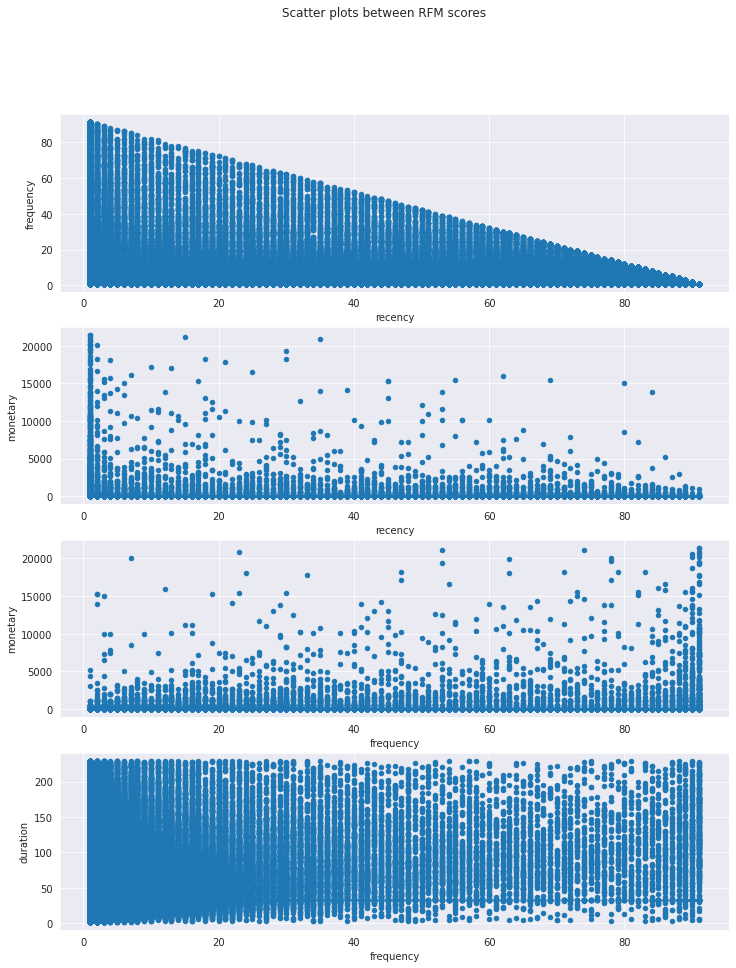

In [54]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.suptitle('Scatter plots between RFM scores')
rfmdSegmentation.plot.scatter(x = 'recency', y = 'frequency', ax = ax1, figsize = (12,15));
rfmdSegmentation.plot.scatter(x = 'recency', y = 'monetary', ax = ax2);
rfmdSegmentation.plot.scatter(x = 'frequency', y = 'monetary', ax = ax3);
rfmdSegmentation.plot.scatter(x = 'frequency', y = 'duration', ax = ax4);

In [70]:
columns_for_clustering = ["duration", "recency","frequency", "monetary"]

df_features = df[columns_for_clustering]

df_features.describe()

,duration,recency,frequency,monetary
count,741531.000000,741531.000000,741531.000000,741531.000000
mean,34.744268,53.337453,3.103842,9.940060
std,32.375472,27.019753,6.655350,254.406216
min,2.000017,1.000000,1.000000,0.000000
25%,14.633300,32.000000,1.000000,0.000000
50%,24.989283,57.000000,1.000000,0.000000
75%,43.482517,78.000000,3.000000,0.000000
max,229.794418,91.000000,91.000000,21400.000000


In [75]:
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(df_features)

In [76]:
customers_scaled = pd.DataFrame(customers_scaled, 
                                columns = ["duration", "recency","frequency", "monetary"])
customers_scaled.describe().round(2)

,duration,recency,frequency,monetary
count,741531.00,741531.00,741531.00,741531.00
mean,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-1.01,-1.94,-0.32,-0.04
25%,-0.62,-0.79,-0.32,-0.04
50%,-0.30,0.14,-0.32,-0.04
75%,0.27,0.91,-0.02,-0.04
max,6.02,1.39,13.21,84.08


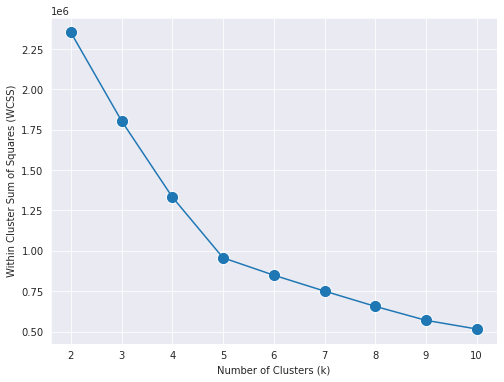

In [77]:
wcss = []
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(customers_scaled)#
    wcss.append(km.inertia_)

wcss_series = pd.Series(wcss, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Within Cluster Sum of Squares (WCSS)')

In [78]:
k = 5

kmeans = KMeans(n_clusters=k, random_state=1) 
kmeans.fit(customers_scaled)
cluster_labels = kmeans.labels_
# df_clustered = df.assign(Cluster=cluster_labels)
df_clustered = customers_scaled.assign(Cluster=cluster_labels)
df_clustered

,duration,recency,frequency,monetary,Cluster
0,-0.911405,-1.418869,-0.015603,-0.039072,0
1,-0.121385,-1.862988,-0.316113,-0.039072,0
2,-1.010368,-1.751958,-0.316113,-0.039072,0
3,-1.011046,-1.899998,-0.165858,-0.039072,0
4,-0.800160,-1.751958,-0.165858,-0.039072,0
...,...,...,...,...,...
741526,3.424646,-1.937008,-0.316113,-0.039072,2
741527,-0.872689,-1.937008,-0.316113,-0.039072,0
741528,0.704104,-1.937008,-0.316113,-0.039072,0
741529,-0.459674,-1.937008,-0.316113,-0.039072,0


In [80]:
from sklearn import metrics

In [ ]:
inertias = []
ss = []

for k in range(2,11):
    
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(customers_scaled)
    inertias.append(kmeans.inertia_)
    ss.append(metrics.silhouette_score(customers_scaled, kmeans.labels_, metric='euclidean'))

In [ ]:
columns_for_clustering = ["duration", "recency","frequency", "monetary"]

df_features = df[columns_for_clustering]

df_features.describe()

,duration,recency,frequency,monetary
count,758599.000000,758599.000000,758599.000000,758599.000000
mean,33.988705,53.403610,3.058708,9.719513
std,32.394371,26.997991,6.588949,251.536588
min,0.044717,1.000000,1.000000,0.000000
25%,13.883216,33.000000,1.000000,0.000000
50%,24.423542,57.000000,1.000000,0.000000
75%,42.820117,78.000000,3.000000,0.000000
max,229.794418,91.000000,91.000000,21400.000000


In [ ]:
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(df_features)

In [ ]:
customers_scaled = pd.DataFrame(customers_scaled, 
                                columns = ["duration", "recency","frequency", "monetary"])
customers_scaled.describe().round(2)

In [ ]:
customers_scaled.describe().round(2)

,duration,recency,frequency,monetary
count,758599.00,758599.00,758599.00,758599.00
mean,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-1.05,-1.94,-0.31,-0.04
25%,-0.62,-0.76,-0.31,-0.04
50%,-0.30,0.13,-0.31,-0.04
75%,0.27,0.91,-0.01,-0.04
max,6.04,1.39,13.35,85.04


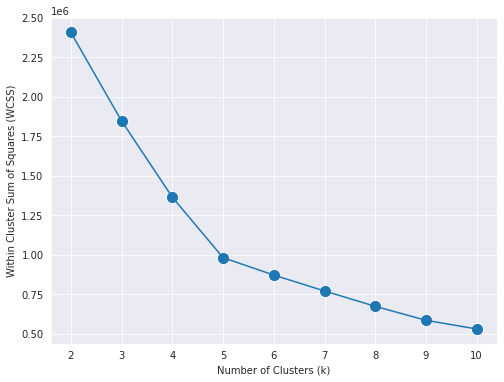

In [ ]:
wcss = []
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(customers_scaled)#
    wcss.append(km.inertia_)

wcss_series = pd.Series(wcss, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Within Cluster Sum of Squares (WCSS)')

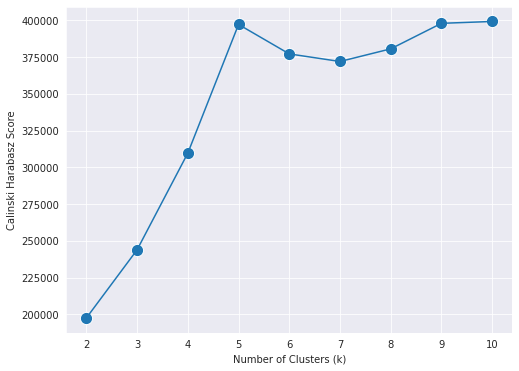

In [ ]:
calinski = []
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234)
    km.fit(customers_scaled) #
    calinski.append(calinski_harabasz_score(customers_scaled, km.labels_)) #

calinski_series = pd.Series(calinski, index = range(2, 11))

plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = calinski_series, x = calinski_series.index)
ax = sns.scatterplot(y = calinski_series, x = calinski_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Calinski Harabasz Score')

In [ ]:
km = KMeans(n_clusters = 5, n_init = 25, random_state = 1234)

In [ ]:
km.fit(customers_scaled)

KMeans(n_clusters=5, n_init=25, random_state=1234)

In [ ]:
km.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
km.inertia_

980557.6464518008

Không scale

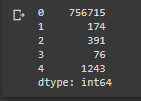

Scale

In [ ]:
pd.Series(km.labels_).value_counts().sort_index()

0    274230
1    397281
2       387
3      9788
4     76913
dtype: int64

In [ ]:
km.cluster_centers_

array([[-2.30724659e-01, -1.00699382e+00, -1.45009221e-02,
        -3.49969272e-02],
       [-3.16265879e-01,  7.38180289e-01, -2.05413295e-01,
        -3.66966948e-02],
       [ 2.16809428e+00, -1.48390858e+00,  9.01254311e+00,
         3.72382106e+01],
       [ 1.70787107e+00, -1.47850882e+00,  6.94088582e+00,
         1.04723222e+00],
       [ 2.22778261e+00, -2.69029943e-02,  1.84310625e-01,
        -6.27219365e-03]])

In [ ]:
cluster_centers = pd.DataFrame(km.cluster_centers_, columns = ["duration", "recency","frequency", "monetary"])
cluster_centers

,duration,recency,frequency,monetary
0,-0.230725,-1.006994,-0.014501,-0.034997
1,-0.316266,0.738180,-0.205413,-0.036697
2,2.168094,-1.483909,9.012543,37.238211
3,1.707871,-1.478509,6.940886,1.047232
4,2.227783,-0.026903,0.184311,-0.006272


In [ ]:
k = 5

kmeans = KMeans(n_clusters=k, random_state=1) 
kmeans.fit(customers_scaled)
cluster_labels = kmeans.labels_
# df_clustered = df.assign(Cluster=cluster_labels)
df_clustered = customers_scaled.assign(Cluster=cluster_labels)
df_clustered

,duration,recency,frequency,monetary,Cluster
0,-0.887550,-1.422463,-0.008910,-0.038641,1
1,-0.097990,-1.866940,-0.312449,-0.038641,1
2,-0.986455,-1.755821,-0.312449,-0.038641,1
3,-0.987132,-1.903980,-0.160679,-0.038641,1
4,-0.776369,-1.755821,-0.160679,-0.038641,1
...,...,...,...,...,...
758594,-0.848856,-1.941020,-0.312449,-0.038641,1
758595,0.727017,-1.941020,-0.312449,-0.038641,1
758596,-0.436082,-1.941020,-0.312449,-0.038641,1
758597,-1.011322,-1.941020,-0.312449,-0.038641,1


In [ ]:
df_sizes = df_clustered.groupby(["Cluster"], as_index=False).size()
df_sizes

,Cluster,size
0,0,397293
1,1,274236
2,2,387
3,3,76896
4,4,9787


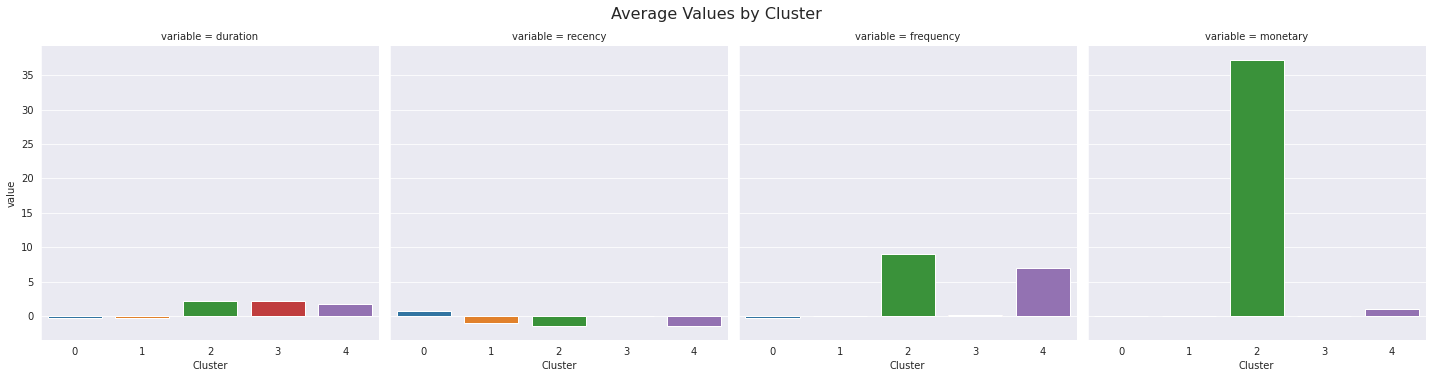

In [ ]:
df_means = df_clustered.groupby(["Cluster"])[df_features.columns].mean().reset_index()

sns.catplot(
    data=df_means.melt(id_vars="Cluster"), 
    col="variable",
    x="Cluster",
    y="value",
    kind="bar",
)

plt.suptitle("Average Values by Cluster", y=1.04, fontsize=16)

plt.show()

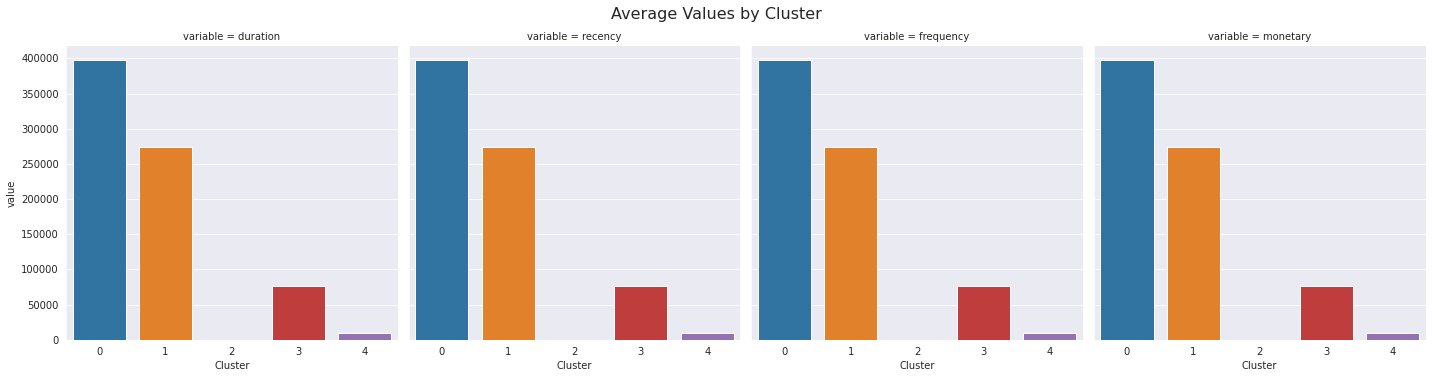

In [ ]:
df_count = df_clustered.groupby(["Cluster"])[df_features.columns].count().reset_index()

sns.catplot(
    data=df_count.melt(id_vars="Cluster"), 
    col="variable",
    x="Cluster",
    y="value",
    kind="bar",
)

plt.suptitle("Average Values by Cluster", y=1.04, fontsize=16)

plt.show()

In [ ]:
df['Cluster'] = km.labels_.tolist()
df.head(10)

,recency,monetary,frequency,duration,Cluster
0,15,0.0,3,5.237117,0
1,3,0.0,1,30.814383,0
2,6,0.0,1,2.033133,0
3,2,0.0,2,2.011192,0
4,6,0.0,2,8.838725,0
5,6,0.0,2,2.743375,0
6,6,0.0,1,0.534817,0
7,2,0.0,11,32.722623,0
8,5,0.0,5,64.672188,0
9,3,0.0,5,152.894824,4


In [ ]:
df.groupby('Cluster').agg({
    'recency': 'min',
    'frequency': 'min',
    'duration': 'min',
    'monetary': 'min'}).round(2)

,recency,frequency,duration,monetary
Cluster,,,,
0,1,1,0.04,0.0
1,49,1,0.05,0.0
2,1,1,12.81,4800.0
3,1,10,1.74,0.0
4,1,1,47.79,0.0


In [ ]:
df.groupby('Cluster').agg({
    'recency': 'max',
    'frequency': 'max',
    'duration': 'max',
    'monetary': 'max'}).round(2)

,recency,frequency,duration,monetary
Cluster,,,,
0,61,29,85.65,4350.0
1,91,29,76.52,4450.0
2,86,91,226.70,21400.0
3,73,91,229.64,4900.0
4,91,30,229.79,4000.0


In [ ]:
df.groupby('Cluster').agg({
    'recency': 'count',
    'frequency': 'count',
    'duration': 'count',
    'monetary': 'count'}).round(2)

,recency,frequency,duration,monetary
Cluster,,,,
0,274230,274230,274230,274230
1,397281,397281,397281,397281
2,387,387,387,387
3,9788,9788,9788,9788
4,76913,76913,76913,76913


In [ ]:
df.groupby('Cluster').agg({
    'recency': 'describe',
    'frequency': 'describe',
    'duration': 'describe',
    'monetary': 'describe'}).round(2).to_csv("3T_clustering.csv")

In [ ]:
df.groupby('Cluster').agg({
    'recency': 'describe',
    'frequency': 'describe',
    'duration': 'describe',
    'monetary': 'describe'}).round(2)

recency                                             frequency  \
            count   mean    std   min   25%   50%   75%   max     count   
Cluster                                                                   
0        274230.0  26.22  14.91   1.0  13.0  28.0  39.0  61.0  274230.0   
1        397281.0  73.33  12.61  49.0  62.0  75.0  85.0  91.0  397281.0   
2           387.0  13.34  20.41   1.0   1.0   1.0  18.0  86.0     387.0   
3          9788.0  13.49  16.76   1.0   1.0   4.0  22.0  73.0    9788.0   
4         76913.0  52.68  25.26   1.0  36.0  56.0  74.0  91.0   76913.0   

                ... duration          monetary                            \
          mean  ...      75%     max     count     mean      std     min   
Cluster         ...                                                        
0         2.96  ...    37.13   85.65  274230.0     0.92    33.07     0.0   
1         1.71  ...    32.86   76.52  397281.0     0.49    24.11     0.0   
2        62.44  ...   158.38  226.70     387.0  9376.49  4218.99  4800.0   
3        48.79  ...   118.75  229.64    9788.0   273.05   733.24     0.0   
4         4.27  ...   123.06  229.79   76913.0     8.14    91.61     0.0   

                                           
            25%     50%      75%      max  
Cluster                                    
0           0.0     0.0      0.0   4350.0  
1           0.0     0.0      0.0   4450.0  
2        6000.0  8000.0  11375.0  21400.0  
3           0.0     0.0      0.0   4900.0  
4           0.0     0.0      0.0   4000.0  

[5 rows x 32 columns]

In [ ]:
df_cm = df.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'duration': 'mean',
    'monetary': 'mean'}).round(2)

In [ ]:
df_cm.mean()

recency        35.812
frequency      24.034
duration       69.988
monetary     1931.818
dtype: float64

In [ ]:
df.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'duration': 'mean',
    'monetary': 'mean'}).round(2)
# 0: R↓ F↓ D↓ M↓ -> 5
# 1: R↑ F↓ D↓ M↓ -> 3
# 2: R↓ F↑ D↑ M↑ -> 1
# 3: R↓ F↑ D↑ M↓ -> 4
# 4: R↑ F↓ D↑ M↓ -> 2

,recency,frequency,duration,monetary
Cluster,,,,
0,26.22,2.96,26.51,0.92
1,73.33,1.71,23.74,0.49
2,13.34,62.44,104.22,9376.49
3,13.49,48.79,89.31,273.05
4,52.68,4.27,106.16,8.14


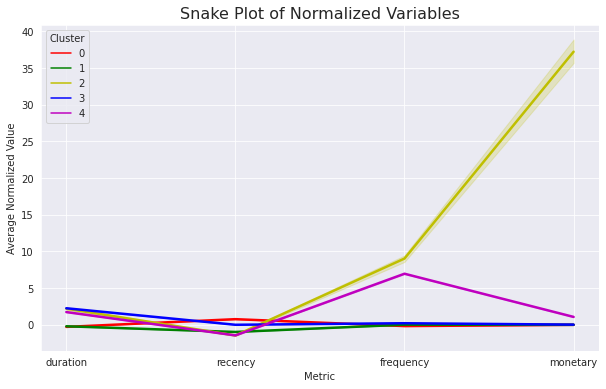

In [ ]:
df_processed_clustered = df_clustered.assign(Cluster=cluster_labels)

df_processed_melt = pd.melt(
    df_processed_clustered.reset_index(),
    id_vars=['Cluster'],
    value_vars=df_features.columns,
    var_name="Metric",
    value_name="Value",
)

plt.figure(figsize=(10, 6))

plt.title('Snake Plot of Normalized Variables', fontsize=16)
plt.xlabel('Metric')
plt.ylabel('Average Normalized Value')

sns.lineplot(data=df_processed_melt, x='Metric', y='Value', hue='Cluster', palette=['r', 'g', 'y', 'b', 'm'], linewidth=2.5)
plt.show()

In [ ]:
filter_0 = df[df['Cluster'] == 0]
filter_0

,duration,recency,frequency,monetary,Cluster
1,27.534874,16,1,0.0,0
5,27.534874,30,1,0.0,0
6,27.534874,27,4,2000.0,0
8,27.534874,18,9,0.0,0
11,27.534874,16,1,0.0,0
...,...,...,...,...,...
293295,2.002183,15,1,0.0,0
293296,2.002033,29,1,0.0,0
293297,2.001817,22,1,0.0,0
293298,2.001567,23,1,0.0,0


In [ ]:
filter_1 = df[df['Cluster'] == 1]
filter_1

,duration,recency,frequency,monetary,Cluster
0,27.534874,0,3,0.0,1
2,27.534874,0,7,300.0,1
4,27.534874,13,1,0.0,1
9,27.534874,9,1,0.0,1
12,27.534874,1,1,0.0,1
...,...,...,...,...,...
293300,2.001217,11,1,0.0,1
293301,2.000583,13,1,0.0,1
293302,2.000483,10,1,0.0,1
293303,2.000117,8,1,0.0,1


In [ ]:
filter_2 = df[df['Cluster'] == 2]
filter_2.describe()

,recency,monetary,frequency,duration,Cluster
count,387.000000,387.000000,387.000000,387.000000,387.0
mean,13.341085,9376.485788,62.441860,104.222709,2.0
std,20.413661,4218.989584,27.234895,64.006485,0.0
min,1.000000,4800.000000,1.000000,12.809708,2.0
25%,1.000000,6000.000000,40.000000,32.722623,2.0
50%,1.000000,8000.000000,69.000000,100.429324,2.0
75%,18.000000,11375.000000,89.000000,158.380723,2.0
max,86.000000,21400.000000,91.000000,226.702226,2.0


In [ ]:
filter_2.tail()

,recency,monetary,frequency,duration,Cluster
652516,2,6500.0,24,160.743927,2
658551,13,11100.0,15,93.831395,2
716665,9,6500.0,3,32.151089,2
732482,1,10000.0,9,32.722623,2
735826,1,20050.0,7,32.722623,2
